# Spark Initialization

In [1]:
import os, atexit, re, uuid, itertools, ast, json, io, sys
from IPython.display import display, HTML
from datetime import datetime
if 'spark' not in vars():
    import findspark
    findspark.init()
    from pyspark.sql import SparkSession, DataFrame
    from pyspark.sql.window import Window
    import pyspark.sql.types as T
    import pyspark.sql.functions as F
    from pyspark.storagelevel import StorageLevel
    spark = SparkSession.builder.master("local[8,2]").config(
        'spark.driver.memory', '1g').enableHiveSupport().getOrCreate()
    atexit.register(lambda: spark.stop())

from pyspark.sql import SparkSession, DataFrame, Row
from pyspark.sql.window import Window
import pyspark.sql.types as T
import pyspark.sql.functions as F


def cleanse_val(val):
    return re.sub(r'([^\s\w\d])+', '', val.lower()).strip() if val else ''


def reg(spark_df, name=None):
    uniqsig = 'df_{0}'.format(cleanse_val(str(
        uuid.uuid4()))) if not name else name
    spark_df.createOrReplaceTempView(uniqsig)
    return uniqsig


def show(df, rows=5):
    display(df.limit(rows).toPandas())

# Override table show/registration functions
DataFrame.reg = reg
DataFrame.dshow = show

# Hadoop Utilities

In [2]:
sc = spark.sparkContext

import os
from pyspark import *
from pyspark.sql import *

_conf = sc._jsc.hadoopConfiguration()
# Get Spark/Hadoop file system
_fs = sc._jvm.org.apache.hadoop.fs.FileSystem.get(_conf)


# Return HDFS Path object from String
def _path(path):
    return sc._jvm.org.apache.hadoop.fs.Path(path)


# Given a HDFS directory path, report number of containers that can ideally process this "chunk" of work unit
def _blocks(path):
    return round(0.5 + _fs.getUsed(_path(path)) /
                 _fs.getDefaultBlockSize(_path(path)))


# List files of a HDFS path
def _listFiles(path):
    return [file.getPath().toString() for file in _fs.globStatus(_path(path))]


# Compute a unique file ID for every HDFS path
def _fileid(path):
    return str(abs(hash(os.path.basename(path))))


# Duplicate processable objects to a temporary directory (helps keep the processes consistent)
def _moveFiles(paths, dest, delete_source=False):
    return {
        _fileid(path): path
        for path in paths if sc._jvm.org.apache.hadoop.fs.FileUtil.copy(
            _fs, _path(path), _fs, _path(f'{dest}/{_fileid(path)}'),
            delete_source, True, _conf)
    }

# Data Integration from Web

In [3]:
import pandas as pd
airports = spark.createDataFrame(
    pd.read_csv('http://ourairports.com/data/airports.csv',
                dtype=str).fillna(''))

In [4]:
airports.dshow()

id ident           type                                name  \
0    6523   00A       heliport                   Total Rf Heliport   
1  323361  00AA  small_airport                Aero B Ranch Airport   
2    6524  00AK  small_airport                        Lowell Field   
3    6525  00AL  small_airport                        Epps Airpark   
4    6526  00AR         closed  Newport Hospital & Clinic Heliport   

        latitude_deg       longitude_deg elevation_ft continent iso_country  \
0     40.07080078125  -74.93360137939453           11                    US   
1          38.704022         -101.473911         3435                    US   
2        59.94919968      -151.695999146          450                    US   
3  34.86479949951172  -86.77030181884766          820                    US   
4            35.6087          -91.254898          237                    US   

  iso_region  municipality scheduled_service gps_code iata_code local_code  \
0      US-PA      Bensalem                no      00A                  00A   
1      US-KS         Leoti                no     00AA                 00AA   
2      US-AK  Anchor Point                no     00AK                 00AK   
3      US-AL       Harvest                no     00AL                 00AL   
4      US-AR       Newport                no                                 

  home_link wikipedia_link keywords  
0                                    
1                                    
2                                    
3                                    
4                              00AR

# Save to Warehouse

In [5]:
airports.write.saveAsTable('airports', mode='overwrite')
airports.dshow()

id ident           type                                name  \
0    6523   00A       heliport                   Total Rf Heliport   
1  323361  00AA  small_airport                Aero B Ranch Airport   
2    6524  00AK  small_airport                        Lowell Field   
3    6525  00AL  small_airport                        Epps Airpark   
4    6526  00AR         closed  Newport Hospital & Clinic Heliport   

        latitude_deg       longitude_deg elevation_ft continent iso_country  \
0     40.07080078125  -74.93360137939453           11                    US   
1          38.704022         -101.473911         3435                    US   
2        59.94919968      -151.695999146          450                    US   
3  34.86479949951172  -86.77030181884766          820                    US   
4            35.6087          -91.254898          237                    US   

  iso_region  municipality scheduled_service gps_code iata_code local_code  \
0      US-PA      Bensalem                no      00A                  00A   
1      US-KS         Leoti                no     00AA                 00AA   
2      US-AK  Anchor Point                no     00AK                 00AK   
3      US-AL       Harvest                no     00AL                 00AL   
4      US-AR       Newport                no                                 

  home_link wikipedia_link keywords  
0                                    
1                                    
2                                    
3                                    
4                              00AR

# Terminate Spark Session

In [6]:
spark.stop()

# Consumption

In [7]:
%load_ext sql
%config SqlMagic.autocommit=False

## Presto

In [8]:
%sql --connection_arguments '{"protocol": "http"}' presto://admin@presto:8080/minio

In [9]:
%%sql results_set <<
select iso_country, iso_region, count(*) as ct from airports where type is not null and trim(type) <> '' and type = 'large_airport' group by iso_country, iso_region order by ct desc

 * presto://admin@presto:8080/minio
Done.
Returning data to local variable results_set


In [10]:
df = results_set.DataFrame()
df

iso_country iso_region  ct
0            GB     GB-ENG  20
1            US      US-TX  15
2            US      US-FL  15
3            US      US-CA  13
4            US      US-IL   8
..          ...        ...  ..
424          BO       BO-S   1
425          RU     RU-ROS   1
426          US      US-NH   1
427          ES       ES-M   1
428          AT       AT-9   1

[429 rows x 3 columns]

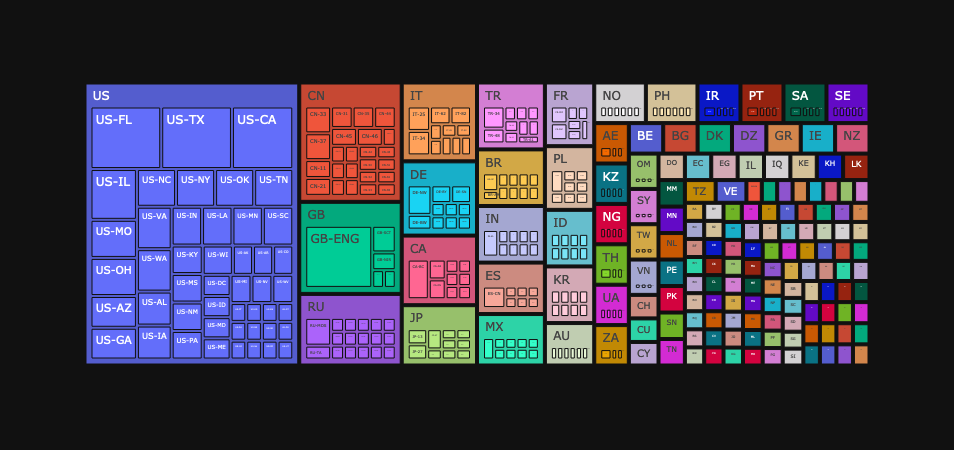

In [11]:
import plotly.express as px
fig = px.treemap(df, path=['iso_country', 'iso_region'], values='ct', template='plotly_dark')
fig.show()

## Spark Beeline

In [12]:
%sql hive://admin@localhost:10000/default?auth=NOSASL

In [13]:
%%sql results_set <<
select iso_country, iso_region, count(*) as ct from airports where type is not null and trim(type) <> '' and type = 'large_airport' group by iso_country, iso_region order by ct desc

 * hive://admin@localhost:10000/default?auth=NOSASL
   presto://admin@presto:8080/minio
Done.
Returning data to local variable results_set


In [14]:
df = results_set.DataFrame()
df

iso_country iso_region  ct
0            GB     GB-ENG  20
1            US      US-TX  15
2            US      US-FL  15
3            US      US-CA  13
4            US      US-IL   8
..          ...        ...  ..
424          CN      CN-14   1
425          BH      BH-15   1
426          MX     MX-SON   1
427          IE       IE-C   1
428          NG      NG-KN   1

[429 rows x 3 columns]

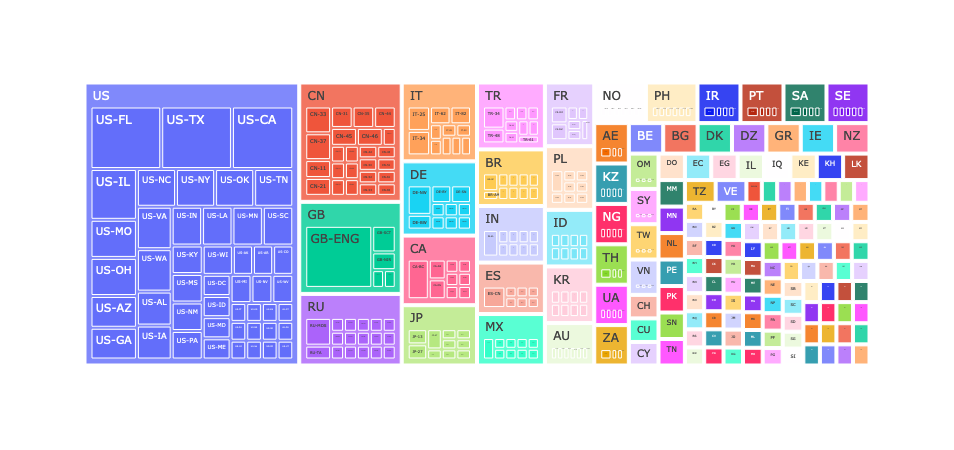

In [15]:
import plotly.express as px
fig = px.treemap(df, path=['iso_country', 'iso_region'], values='ct', template='plotly')
fig.show()